In [1]:
# Data preprocessing
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import os
import json

# Plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, ConnectionPatch, Circle, Arc
%matplotlib inline
import seaborn as sns
import scikitplot as skplt
import plotly.graph_objects as go
import networkx as nx

%load_ext autoreload
%autoreload 2

In [2]:
from parser import Competitions, Events, Matches, Lineups

In [3]:
comps = Competitions().get_data()
comps

,competition_gender,competition_id,competition_name,country_name,match_available,match_updated,season_id,season_name
0,female,37,FA Women's Super League,England,2019-06-23T15:32:29.914,2019-06-23T15:32:29.914,4,2018/2019
1,male,43,FIFA World Cup,International,2019-06-23T12:38:35.142,2019-06-23T12:38:35.142,3,2018
2,male,11,La Liga,Spain,2019-07-29T20:44:30.861,2019-07-29T20:44:30.861,27,2015/2016
3,male,11,La Liga,Spain,2019-07-30T12:42:05.563,2019-07-30T12:42:05.563,26,2014/2015
4,male,11,La Liga,Spain,2019-07-24T19:44:48.866,2019-07-24T19:44:48.866,25,2013/2014
5,male,11,La Liga,Spain,2019-07-29T17:46:18.935,2019-07-29T17:46:18.935,24,2012/2013
6,male,11,La Liga,Spain,2019-07-11T16:55:27.568,2019-07-11T16:55:27.568,23,2011/2012
7,male,11,La Liga,Spain,2019-08-01T17:44:54.870,2019-08-01T17:44:54.870,22,2010/2011
8,male,11,La Liga,Spain,2019-07-11T07:44:14.533,2019-07-11T07:44:14.533,21,2009/2010
9,male,11,La Liga,Spain,2019-07-06T22:42:14.468,2019-07-06T22:42:14.468,41,2008/2009


In [4]:
nwsl_matches = Matches(competition_id = '49', season_id = '3').get_data()
fawsl_matches = Matches(competition_id = '37', season_id = '4').get_data()
wwc_matches = Matches(competition_id = '72', season_id = '30').get_data()

In [5]:
arsenal = ((fawsl_matches['away_team.away_team_name'] == 'Arsenal WFC') | (fawsl_matches['home_team.home_team_name'] == 'Arsenal WFC'))
arsenal_games = fawsl_matches.loc[arsenal]
arsenal_ids = arsenal_games['match_id']

In [6]:
def identify_half(row):
    if row['timestamp'].total_seconds() <= (row['minute'] * 60):
        return 'second'
    return 'first'

In [7]:
def draw_pitch(ax):

    #Pitch Outline & Centre Line
    pitch = Rectangle([0,0], width = 120, height = 80, fill = False)
    center_line = ConnectionPatch([60, 0], [60, 80], 'data')

    #Penalty boxes
    left_penalty = Rectangle([0, 18], width = 18, height = 44, fill = False)
    right_penalty = Rectangle([102, 18], width = 18, height = 44, fill = False)

    #Six-yard box
    left_box = Rectangle([0, 30], width = 6, height = 20, fill = False)
    right_box = Rectangle([114, 30], width = 6, height = 20, fill = False)

    #Penalty spots
    left_spot = Circle([12, 40], 1)
    right_spot = Circle([108, 40], 1)

    #Center circle
    center_circle = Circle([60, 40], 9.15, fill = False)
    center_spot = Circle([60, 40], 1)

    #Arcs
    left_arc = Arc([12, 40], height = 18.3, width = 18.3, angle = 0, theta1 = 310, theta2 = 50)
    right_arc = Arc([108, 40], height = 18.3, width = 18.3, angle = 0, theta1 = 130, theta2 = 230)

    #Goals
    left_goal = Rectangle([-2.42, 36], height = 8, width = 2.42, fill = False)
    right_goal = Rectangle([120, 36], height = 8, width = 2.42, fill = False)

    #Corner arcs
    bottom_left = Arc([0, 0], height = 2, width = 2, angle = 0, theta1 = 0, theta2 = 90)
    top_left = Arc([0, 80], height = 2, width = 2, angle = 0, theta1 = 270, theta2 = 0)
    bottom_right = Arc([120, 0], height = 2, width = 2, angle = 0, theta1 = 90, theta2 = 180)
    top_right = Arc([120, 80], height = 2, width = 2, angle = 0, theta1 = 180, theta2 = 270)

    pitch_elements = [pitch, center_line, left_penalty, right_penalty,
                      left_box, right_box, left_spot, right_spot,
                      center_circle, center_spot, left_arc, right_arc,
                     left_goal, right_goal, bottom_left, top_left,
                     bottom_right, top_right]

    for element in pitch_elements:
        ax.add_patch(element)

In [8]:
data = Events(match_id = arsenal_ids.iloc[0]).get_player_data('Vivianne Miedema')
data['type.name'].value_counts()

Ball Receipt*    78
Carry            68
Pass             55
Shot             12
Pressure         11
Ball Recovery     7
Dribble           3
Block             3
Miscontrol        2
Dispossessed      2
Interception      1
Dribbled Past     1
Name: type.name, dtype: int64

In [12]:
viv_pass = data.loc[data['type.name'] == 'Pass'].copy()
viv_pass.loc[:, 'timestamp'] = pd.to_timedelta(viv_pass.loc[:, 'timestamp'])
viv_pass.loc[:, 'half'] = viv_pass.apply(identify_half, axis = 1)

In [10]:
viv_shots = data.loc[data['type.name'] == 'Shot']
viv_shots.loc[:, 'timestamp'] = pd.to_timedelta(viv_shots.loc[:, 'timestamp'])
viv_shots.loc[:, 'half'] = viv_shots.apply(identify_half, axis = 1)

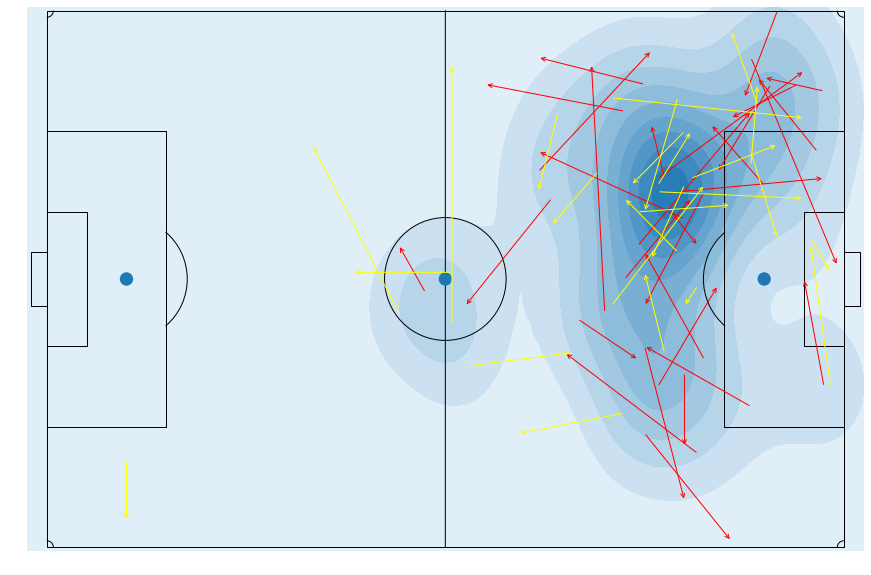

In [29]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_subplot(1, 1, 1)

sns.kdeplot([x[0] for x in viv_pass['location']], [x[1] for x in viv_pass['location']], shade = True)

first_half = viv_pass.loc[viv_pass['half'] == 'first']
second_half = viv_pass.loc[viv_pass['half'] == 'second']

# second_half['pass.end_location'] = second_half['pass.end_location'].apply(lambda x: [(120 - x[0]), x[1]])
# second_half['location'] = second_half['location'].apply(lambda x: [(120 - x[0]), x[1]])

for i in range(len(first_half)):
    ax.annotate("",
                xy = (first_half.iloc[i]['pass.end_location'][0], first_half.iloc[i]['pass.end_location'][1]), xycoords='data',
                xytext=(first_half.iloc[i]['location'][0], first_half.iloc[i]['location'][1]), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                color='red')
               )
    
for i in range(len(second_half)):
    ax.annotate("",
                xy = (second_half.iloc[i]['pass.end_location'][0], second_half.iloc[i]['pass.end_location'][1]), xycoords='data',
                xytext=(second_half.iloc[i]['location'][0], second_half.iloc[i]['location'][1]), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                color='yellow')
               )

plt.ylim(-0.5, 80.5)
plt.xlim(-3, 123)

draw_pitch(ax)

plt.axis('off')
plt.show()

In [41]:
[column for column in data.columns if 'location' in column]

['carry.end_location', 'location', 'pass.end_location', 'shot.end_location']